# Sea Level Rise Mapping

In [31]:
import numpy as np
import matplotlib
import pandas as pd
import requests
import json
import time
from numpy.polynomial import Chebyshev
from mpl_toolkits import mplot3d
from matplotlib import animation, rc
from IPython.display import HTML
from IPython.display import clear_output
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

# We are going to make a topographical map of the world relative to the latitude-longitude coordinate.

In [2]:
step=1
longitude = np.arange(-180, 180+1, step)
latitude = np.arange(-85, 85+1, step)
grid = np.zeros(shape=(len(longitude),len(latitude)))

In [4]:
# data sets can be found at https://www.jawg.io/en/

def jprint(obj):
    
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    clear_output()
    print(text)

for i, i_val in enumerate(longitude): # longitude, this will allow for api requests time constraint management
    clear_output()
    print("Longitude: " + str(i_val))
    # create api url
    url = ""
    my_access_token="KELYrtFKi5rbmtGgba7sTpfe4lVIa4N2NUV6qs0vCsq4IufjRI6VVugh9799sPJ1" # confidential
    
    for j, j_val in enumerate (latitude): # latitude
        if (j==0):
            url += "https://api.jawg.io/elevations?locations="
            url += str(j_val) + "," + str(i_val)
        else:
            url += "|" + str(j_val) + "," + str(i_val)
            
    url+="&access-token="+my_access_token
    
    response = requests.get(url)
    for resp in (response.json()):
        grid[int(resp['location']['lng']-longitude[0]),int(resp['location']['lat']-latitude[0])] = resp['elevation']
    time.sleep(1) # api time constraint

180


# We can visualize the topography of the earth above see level in a contour graph or in a heatmap.

Text(0.5, 0, 'Elevation')

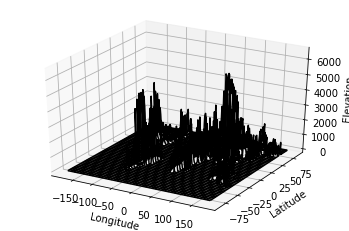

In [5]:
# Can use %matplotlib notebook to have rotation interactive

fig = plt.figure()
ax = plt.axes(projection='3d')


longitude_grid, latitude_grid = np.meshgrid(longitude, latitude)
ax.plot_wireframe(longitude_grid, latitude_grid, grid.transpose(), color='black')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Elevation')

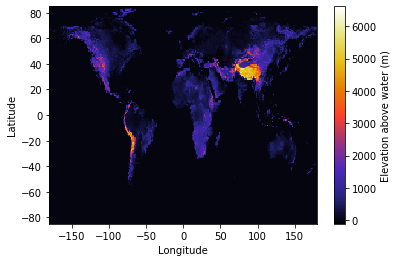

In [11]:
fig, ax = plt.subplots()

ax = plt.pcolor(longitude_grid, latitude_grid, grid.transpose(), cmap='CMRmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar = plt.colorbar(ax)
cbar.set_label('Elevation above water (m)')

# We analyze the sea level and extrapolate it using chebyshev fit. It turns out this is not ver useful and that we are better off using a linear model.

C:\Users\ngren\Anaconda3\lib\site-packages\pandas\io\parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


<Figure size 432x288 with 0 Axes>

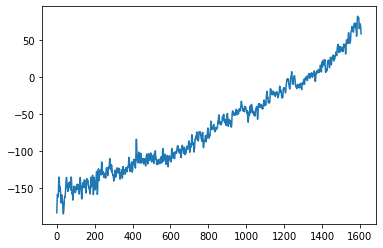

In [12]:
headers = ['Time','GMSL','GMSL','uncertainty']
sea_level = pd.read_csv('sea_level.csv', names=headers)

level = sea_level['GMSL'].to_numpy()
level = np.delete(level, 0)
level = level.astype(np.float)

plt.clf()
fig,ax = plt.subplots(1)
time = np.arange(0, len(sea_level['Time'])-1, 1)

ax.plot(time, level)
plt.show()

Residuals squared: 14500.44989946051


<Figure size 432x288 with 0 Axes>

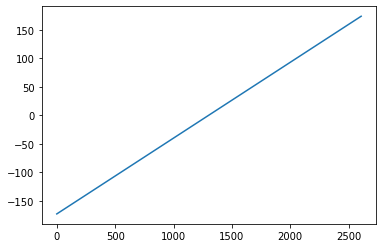

In [14]:
order=1

pp=Chebyshev.fit(time,level,order)


tt = np.arange(0, (len(sea_level['Time'])-1) + 1000, 1) # new time range
new_level = pp(tt)

res2=0
for i, val in enumerate(pp(time)):
    res2+=np.abs(val - level[i])
print("Residuals squared: " + str(res2))
    
plt.clf()
fig,ax = plt.subplots(1)
ax.plot(tt, new_level)
plt.show()

# Using the data fitted above or a linear model of sea water rise, we modify the elevation map at every point and get new flood maps.

In [15]:
ref_height = np.copy(grid)

time_margin=2000
grid_time = np.zeros(shape=(len(longitude),len(latitude),time_margin+1))
sea_rises = np.arange(0, time_margin+1, 1)

for sea_rise in sea_rises:
    clear_output()
    print("Water level rise: " + str(sea_rise))
    for i, i_val in enumerate(grid[:,0]): # longitude
        for j, j_val in enumerate(grid[0]): # latitude
            new_height=ref_height[i,j]-sea_rise

            if(new_height<0):
                new_height=0
            grid_time[i,j,sea_rise]=new_height

Water level rise: 2000


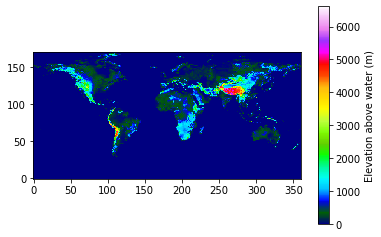

In [24]:
# See the level map at any point
time_stamp=0

fig, ax = plt.subplots()
extents = [longitude[0], longitude[len(longitude)-1], latitude[0] , latitude[len(latitude)-1]]
ax=plt.imshow(grid_time[:,:,time_stamp].transpose(), cmap='gist_ncar', interpolation=None, origin='lower', extent=extents)
cbar = plt.colorbar();
cbar.set_label('Elevation above water (m)')
plt.show()

# Visualize sea level rise:

2000


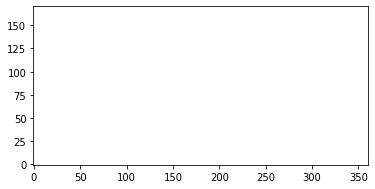

In [32]:
matplotlib.rcParams['animation.embed_limit'] = 2**128 # bigger size animation

fig = plt.figure()

frames=[]
for index in range (len(grid_time[0,0,:])):
    clear_output()
    print(index)
    frames.append([plt.imshow(grid_time[:,:,index].transpose(), cmap='gist_ncar', interpolation=None, origin='lower')])
    

anim = animation.ArtistAnimation(fig, frames, interval=70, blit=False, repeat=False)

HTML(anim.to_jshtml())
anim.save('Earth_Flooding.mp4', fps=60, extra_args=['-vcodec', 'libx264'])

In [44]:
header="shape=()"+str(len(grid_time[:,0,0]))+","+str(len(grid_time[0,:,0]))+","+str(len(grid_time[0,0,:]))
grid_export = np.reshape(np.copy(grid_time), (len(grid_time[:,0,0]),len(grid_time[0,:,0])*len(grid_time[0,0,:])))
np.savetxt("elevations_sealevel.csv", grid_export, delimiter=",",header=header)